In [6]:
# Essentials
import time
import copy
from collections import OrderedDict
import random
import os
from tifffile import TiffFile
from PIL import Image, ImageOps
from pathlib import Path
from tqdm.notebook import tqdm
# Data
import numpy as np
import pandas as pd
# Plot
import matplotlib.pyplot as plt
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
# Torchvision
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
# segmentation_models_pytorch
import segmentation_models_pytorch as smp
# Albumentations
import albumentations as albu
# Local 
from unet import UNet
from LCD import LandCoverData
from dataset import *
from train import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


# Dataset

### Define custom transforms

The motivation behind redefining transforms is that we need to apply the same transform to both mask and image.

In [7]:
LCD = LandCoverData()

In [8]:
train_dir = 'dataset/train'
test_dir = 'dataset/test'

train_idx, val_idx = train_val_dataset(train_dir, val_split=0.2)
train_set = ImageSegementationDataset(train_dir, path_index=train_idx, mode='train')
val_set = ImageSegementationDataset(train_dir, path_index=val_idx, mode='valid')
test_set = ImageSegementationDataset(test_dir, mode='test')

print("Train set contains", len(train_set), "elements")
print("Validation set contains", len(val_set), "elements")
print("Test set contains", len(test_set), "elements")

Train set contains 14792 elements
Validation set contains 3699 elements
Test set contains 5043 elements


In [9]:
batch_size = 8
epochs= 10
lr= 0.001

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(val_set, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(test_set, batch_size=batch_size, shuffle=True)

data_sizes = {"train": len(loader_train), "valid": len(loader_valid)}
print(data_sizes)

{'train': 1849, 'valid': 463}


### Dice Loss

In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_pred_f * y_true_f).sum()
    smooth = 0.0001
    return 1 - (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def change_shape(y_true, y_pred, numLabels):  

    encoded_target = y_pred.data.clone().zero_()
    encoded_target[...] = 0
    encoded_target.scatter_(1, torch.tensor(y_true.unsqueeze(1), dtype=torch.int64), 1.)
    encoded_target = Variable(encoded_target)
    return encoded_target

def dice_coef_multilabel(y_pred, y_true, numLabels):
    dice=0
    y_true = change_shape(y_true, y_pred, numLabels)
    for index in range(numLabels):
        dice += dice_coef(y_true[:,index,:,:], y_pred[:,index,:,:])
    return dice/numLabels # taking average

### IoU Metric

In [11]:
def mIOU(label, pred, num_classes=10):
    iou_list = list()
    present_iou_list = list()

    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    return np.mean(present_iou_list)

### KL Divergence

In [12]:
def epsilon_kl_divergence(y_true, y_pred):
    class_distribution_true = np.apply_along_axis(np.bincount, axis=1, arr=y_true.flatten(1), minlength=LCD.N_CLASSES)
    class_distribution_pred = np.apply_along_axis(np.bincount, axis=1, arr=y_pred.flatten(1), minlength=LCD.N_CLASSES)
    # Normalize to sum to 1  
    normalized_class_distribution_true = (class_distribution_true.T/class_distribution_true.sum(1)).T
    normalized_class_distribution_pred = (class_distribution_pred.T/class_distribution_pred.sum(1)).T
    # add a small constant for smoothness around 0
    normalized_class_distribution_true += 1e-7
    normalized_class_distribution_pred += 1e-7

    score = np.mean(np.sum(normalized_class_distribution_true * np.log(normalized_class_distribution_true / normalized_class_distribution_pred), 1))
    try:
        assert np.isfinite(score)
    except AssertionError as e:
        raise ValueError('score is NaN or infinite') from e
    return score

### Weights

In [13]:
def class_weight():
    weights = np.zeros((LCD.N_CLASSES,))
    num_ign_classes = len(LCD.IGNORED_CLASSES_IDX)
    weights[num_ign_classes:] = (1 / LCD.TRAIN_CLASS_COUNTS[2:])* LCD.TRAIN_CLASS_COUNTS[2:].sum() / (LCD.N_CLASSES-2)
    weights[LCD.IGNORED_CLASSES_IDX] = 0.

    class_weights = torch.FloatTensor(weights)
    return class_weights

# Training the Model

In [14]:
def training(model, train_loader, valid_loader, data_sizes, epochs, optimizer, scheduler, title):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device", device)
    model.to(device)
    
    since = time.time()

    training_loss = []
    validation_loss = []
    num_workers = 1

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loaders = {"train": train_loader, "valid": valid_loader}
    print(data_sizes)
    step = 0

    #class_weights = class_weight().to(device)
    #criterion = nn.CrossEntropyLoss(class_weights)
    criterion = dice_coef_multilabel
    
    for epoch in range(1, epochs+1):
        print(f'Epoch {epoch}/{epochs}')
        print('-' * 10)

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_iou = 0
            running_kl_div = 0

            for image, mask in tqdm(loaders[phase]):
                image = image.to(device)
                mask = mask.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):

                    output = model(image)
                    # print(output)
                    _, preds = torch.max(output, 1)

                    #loss = criterion(output, torch.tensor(mask, dtype=torch.long, device=device).squeeze())
                    # print(preds.size())
                    # print(torch.argmax(output, axis=1).shape)
                    loss = criterion(output, mask.squeeze(), LCD.N_CLASSES)
                

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                # running_corrects += torch.sum(iou_pytorch(output, mask))
                running_iou += mIOU(mask, preds)
                running_kl_div += epsilon_kl_divergence(mask.cpu(), preds.cpu())

            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss/data_sizes[phase]
            epoch_iou = running_iou/data_sizes[phase]
            epoch_kl = running_kl_div/data_sizes[phase]
            if phase == 'train':
                training_loss.append(epoch_loss)
            else:
                validation_loss.append(epoch_loss)

            print('{} Loss: {:.4f} IoU: {:.4f} KL_div: {:.4f}'.format(phase, epoch_loss, epoch_iou, epoch_kl))
            
            if phase == 'valid' and epoch_iou > best_acc:
                best_acc = epoch_iou
                best_model = copy.deepcopy(model.state_dict())

            
    # Plotting the validation loss and training loss
    print('validation loss: ' + str(validation_loss))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model)

    # plot the training and validation loss
    plt.figure()
    plt.plot(training_loss, 'b', label='Training Loss')
    plt.plot(validation_loss, 'r', label='Validation Loss')
    plt.title(title)
    plt.legend()
    plt.show() #Change title for every model

    return model

In [15]:
def train_model(data_dir, model, epochs):
    
    # class_weights = class_weight()

    # Optimizing all parameters
    optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.5)

    # Training the model
    title = 'Variations of the training and validation loss SGD'
    model_ft = training(model, loader_train, loader_valid, data_sizes, epochs, optimizer_ft, exp_lr_scheduler, title)

    return model_ft

# Pre-trained Model

In [17]:
unet_pre_trained = smp.Unet(encoder_name='timm-efficientnet-b3',in_channels=4, classes=10, activation='softmax')
unet_pre_trained.load_state_dict(torch.load("unet_timm-efficientnet-b3_20_epochs.pt", map_location = device))

<All keys matched successfully>

Device cuda:0
{'train': 1849, 'valid': 463}
Epoch 1/10
----------


  0%|          | 0/1849 [00:00<?, ?it/s]

C:\Users\JaggBow\anaconda3\envs\l2s\lib\site-packages\segmentation_models_pytorch\base\modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
<ipython-input-10-78a706cb2fa7>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_target.scatter_(1, torch.tensor(y_true.unsqueeze(1), dtype=torch.int64), 1.)


train Loss: 0.5050 IoU: 0.5670 KL_div: 0.0458


  0%|          | 0/463 [00:00<?, ?it/s]

valid Loss: 0.5039 IoU: 0.5686 KL_div: 0.0446
Epoch 2/10
----------


  0%|          | 0/1849 [00:00<?, ?it/s]

train Loss: 0.5032 IoU: 0.5682 KL_div: 0.0457


  0%|          | 0/463 [00:00<?, ?it/s]

valid Loss: 0.5060 IoU: 0.5643 KL_div: 0.0510
Epoch 3/10
----------


  0%|          | 0/1849 [00:00<?, ?it/s]

train Loss: 0.5016 IoU: 0.5713 KL_div: 0.0428


  0%|          | 0/463 [00:00<?, ?it/s]

valid Loss: 0.5095 IoU: 0.5593 KL_div: 0.0682
Epoch 4/10
----------


  0%|          | 0/1849 [00:00<?, ?it/s]

train Loss: 0.3416 IoU: 0.5658 KL_div: 0.0469


  0%|          | 0/463 [00:00<?, ?it/s]

valid Loss: 0.2304 IoU: 0.5699 KL_div: 0.0407
Epoch 5/10
----------


  0%|          | 0/1849 [00:00<?, ?it/s]

train Loss: 0.2275 IoU: 0.5719 KL_div: 0.0418


  0%|          | 0/463 [00:00<?, ?it/s]

valid Loss: 0.2373 IoU: 0.5620 KL_div: 0.0518
Epoch 6/10
----------


  0%|          | 0/1849 [00:00<?, ?it/s]

train Loss: 0.2260 IoU: 0.5742 KL_div: 0.0398


  0%|          | 0/463 [00:00<?, ?it/s]

valid Loss: 0.2331 IoU: 0.5633 KL_div: 0.0567
Epoch 7/10
----------


  0%|          | 0/1849 [00:00<?, ?it/s]

train Loss: 0.2251 IoU: 0.5763 KL_div: 0.0393


  0%|          | 0/463 [00:00<?, ?it/s]

valid Loss: 0.2312 IoU: 0.5699 KL_div: 0.0357
Epoch 8/10
----------


  0%|          | 0/1849 [00:00<?, ?it/s]

train Loss: 0.2221 IoU: 0.5804 KL_div: 0.0362


  0%|          | 0/463 [00:00<?, ?it/s]

valid Loss: 0.2276 IoU: 0.5755 KL_div: 0.0352
Epoch 9/10
----------


  0%|          | 0/1849 [00:00<?, ?it/s]

train Loss: 0.2222 IoU: 0.5804 KL_div: 0.0365


  0%|          | 0/463 [00:00<?, ?it/s]

valid Loss: 0.2245 IoU: 0.5805 KL_div: 0.0360
Epoch 10/10
----------


  0%|          | 0/1849 [00:00<?, ?it/s]

train Loss: 0.2208 IoU: 0.5818 KL_div: 0.0366


  0%|          | 0/463 [00:00<?, ?it/s]

valid Loss: 0.2288 IoU: 0.5749 KL_div: 0.0405
validation loss: [0.5039185060280703, 0.5060405691936773, 0.5095220787478832, 0.23037145264269723, 0.23733271994742666, 0.23305901246181573, 0.23118316390215707, 0.22758903882222867, 0.22449039300947932, 0.22881265188975675]
Training complete in 94m 7s


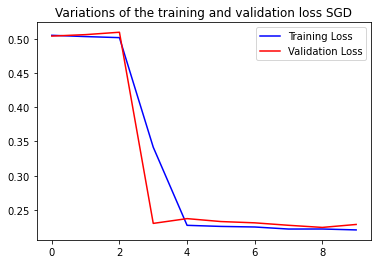

Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(4, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): Swish()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): Swish()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
  

In [18]:
train_model('dataset/train', unet_pre_trained, epochs=10)

In [19]:
running_iou = 0
running_kl_div = 0
unet_pre_trained.eval()
for image, mask in tqdm(loader_valid):
    image = image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        output = unet_pre_trained(image)
        _, preds = torch.max(output, 1)

        running_iou += mIOU(mask, preds)
        running_kl_div += epsilon_kl_divergence(mask.cpu(), preds.cpu())


epoch_iou = running_iou/len(loader_valid)
epoch_kl = running_kl_div/len(loader_valid)

print('Validation IoU', epoch_iou, "Validation KL divergence", epoch_kl)

  0%|          | 0/463 [00:00<?, ?it/s]

Validation IoU 0.5804167071280101 Validation KL divergence 0.0359525565287476


In [20]:
torch.save(unet_pre_trained.state_dict(),"unet_timm-efficientnet-b3_30_epochs.pt")

# Submission time

In [26]:
def batch_distribution(y):
    class_distribution = np.apply_along_axis(np.bincount, axis=1, arr=y.flatten(1), minlength=LCD.N_CLASSES)
    # Normalize to sum to 1  
    return (class_distribution.T/class_distribution.sum(1)).T

In [31]:
LCD.CLASSES

['no_data',
 'clouds',
 'artificial',
 'cultivated',
 'broadleaf',
 'coniferous',
 'herbaceous',
 'natural',
 'snow',
 'water']

In [35]:
sub_dict = {"sample_id":[], "no_data":[],"clouds":[],"artificial":[],"cultivated":[],"broadleaf":[],"coniferous":[],"herbaceous":[],"natural":[],"snow":[],"water":[]}
for image, path in tqdm(loader_test):
    image = image.to(device)
    with torch.no_grad():
        output = unet_pre_trained(image)
        _, preds = torch.max(output, 1)
        class_dis = batch_distribution(preds.cpu())
        sub_dict["sample_id"] += [int(p.split('.')[0]) for p in path]
        for key in LCD.CLASSES:
            sub_dict[key] += class_dis[:,LCD.CLASSES.index(key)].tolist()

  0%|          | 0/631 [00:00<?, ?it/s]

C:\Users\JaggBow\anaconda3\envs\l2s\lib\site-packages\segmentation_models_pytorch\base\modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [38]:
df_sub = pd.DataFrame.from_dict(sub_dict)
df_sub = df_sub.sort_values(by='sample_id')
df_sub.head()

,sample_id,no_data,clouds,artificial,cultivated,broadleaf,coniferous,herbaceous,natural,snow,water
982,10087,0.0,0.0,0.006195,0.235489,0.198532,0.010422,0.543549,0.000351,0.0,0.005463
1585,10088,0.0,0.0,0.004242,0.395966,0.172546,0.004623,0.422394,0.000229,0.0,0.000000
4702,10089,0.0,0.0,0.050873,0.236862,0.218674,0.024994,0.461685,0.000443,0.0,0.006470
4922,10090,0.0,0.0,0.015839,0.031128,0.511948,0.141098,0.299408,0.000580,0.0,0.000000
4339,10091,0.0,0.0,0.025101,0.392700,0.177231,0.025681,0.378784,0.000275,0.0,0.000229


In [39]:
df_sub.to_csv('submission.csv')

# Saving the model

In [ ]:
torch.save(model_ft.state_dict(),"unet.pt")

# Loading the model

In [ ]:
def loading_saved_model(model_name):
    """Loads the saved model"""
    model = unet
    model.load_state_dict(torch.load(model_name, map_location = device))
    model.eval()
    return model

model_loaded = loading_saved_model("unet.pt")

# Prediction of the model

In [19]:
import re

def get_ids(test_images):
    id_list = []
    for test_image in os.listdir(os.path.join(test_images,'images')):
        id_im = int(re.findall(r'\d+', test_image)[0])
        id_list.append(id_im)
    return id_list

In [20]:
column_names = ['no_data', 'clouds', 'artificial', 'cultivated', 'broadleaf', 'coniferous', 'herbaceous', 'natural', 'snow', 'water']

ids_test = np.arange(10)

def compute_class_counts(masks, n_classes):

    dist = np.zeros((masks.size(0), n_classes))

    for i, mask in enumerate(masks):
        arr = mask.cpu().numpy()
        count = np.bincount(arr.ravel(), minlength=n_classes)
        count[0], count[1] = 0, 0
        dist[i] = count/np.sum(count)
    return dist

def getting_pixel_distribution(model, test_loader, test_size, ids):

    indx_test = np.arange(10087,10087+test_size, dtype=np.int32).reshape(-1,1)
    all_dist = np.zeros((test_size, LCD.N_CLASSES))
    previous = 0

    for counter, images in enumerate(tqdm(test_loader)):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        distributions = compute_class_counts(preds, LCD.N_CLASSES)
        all_dist[previous:previous+images.size(0)] = distributions
        previous = previous+images.size(0)

    df = pd.DataFrame(all_dist, columns=column_names)
    df.insert(0, 'Sample_id', ids)

    return df

In [ ]:
test_dir = 'dataset/test'
test_set = ImageSegementationDataset(test_dir, mode='test')
test_loader = DataLoader(test_set, batch_size=batch_size)
test_size = len(test_set)
ids = sorted(get_ids(test_dir))

model_loaded.eval()
df = getting_pixel_distribution(model_loaded, test_loader, test_size, ids)

In [ ]:
def create_from_pandas_csv(df):
    df.to_csv(r'results.csv', index = False)

create_from_pandas_csv(df)